In [86]:
import json

import requests
!pip install --upgrade pip
!pip install torch torchmetrics lightning robust_downloader prettytable matplotlib mlflow

In [3]:
import os
import zipfile
import pickle
from pathlib import Path
import ssl

In [1]:
import torch
import torchmetrics
import torchvision
from PIL import Image
from prettytable import PrettyTable
from robust_downloader import download
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
from torch import nn, log_softmax
from torch.utils.data import Subset, DataLoader
import torchvision.transforms.v2 as transforms
from torchvision.models import ResNet18_Weights, resnet18, resnet50
from torchvision.transforms.functional import to_pil_image
import lightning as L
from lightning.pytorch.loggers import MLFlowLogger

In [4]:
L.seed_everything(123)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

try:
    import google.colab
    IN_COLAB = True
    accelerator="auto"
    assert torch.cuda.is_available()
except:
    IN_COLAB = False
    accelerator = "auto"

print(f"In colab: {IN_COLAB}")

ssl._create_default_https_context = ssl._create_unverified_context

Seed set to 123


Using: cpu
In colab: False


In [5]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

In [6]:
if IN_COLAB:
  SCRIPT_DIR = Path("/content/drive/MyDrive/fhnw_computer_vision_mit_deep_learning_projekt")
else:
  SCRIPT_DIR = Path(os.getcwd())
print(f"Script dir: {SCRIPT_DIR}")
DATA_DIR = SCRIPT_DIR / 'data'
SAVE_DIR = SCRIPT_DIR / 'save'
CHECKPOINTS_DIR = SCRIPT_DIR / 'lightning_logs'
Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

Script dir: /Users/lukaswoodtli/Meine Ablage/fhnw_computer_vision_mit_deep_learning_projekt


In [7]:
url = "https://mostwiedzy.pl/en/open-research-data/lego-bricks-for-training-classification-network,202309140842198941751-0/download/"
filename = 'file 05 - dataset.zip'

def download_and_unpack(url, filename, data_dir):
    data_download_dir = Path(data_dir) / 'download'
    data_download_dir.mkdir(parents=True, exist_ok=True)
    data_archive = data_download_dir / filename
    if not data_archive.exists():
        download(url, data_download_dir, filename)
    data_set_dir = data_dir / 'data_set'
    if not data_set_dir.exists():
        data_set_dir.mkdir(parents=True, exist_ok=True)
        print(data_archive)
        with zipfile.ZipFile(data_archive, 'r') as zipf:
            zipf.extractall(data_set_dir)
    return data_set_dir


data_set_dir = download_and_unpack(url, filename, DATA_DIR)

In [20]:
def verify_image(fn):
    """Confirm that `fn` can be opened (taken from fast.ai)"""
    try:
        im = Image.open(fn)
        im.draft(im.mode, (32,32))
        im.load()
        return True
    except: return False


number_of_classes = 447
photos_data_set = data_set_dir / 'photos'
renders_data_set = data_set_dir / 'renders'
DS_ALL_SAVE_FILE = SAVE_DIR / 'ds_all.pickle'
if DS_ALL_SAVE_FILE.exists():
    with open(DS_ALL_SAVE_FILE, 'rb') as pf:
        ds_all = pickle.load(pf)
else:
    # taken from: https://pytorch.org/hub/pytorch_vision_resnet/
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    # TODO
    data_set_transforms = transforms.Compose(
        [transforms.Grayscale(),
         transforms.Resize((256, 256)),
         transforms.ToTensor().to(torch.float32),
         transforms.Normalize(mean=mean, std=std),

        ]
    )
    ds_fotos = torchvision.datasets.ImageFolder(root=photos_data_set,
                                          transform = data_set_transforms,
                                          is_valid_file = verify_image,
                                          allow_empty = False)
    ds_renders = torchvision.datasets.ImageFolder(root=renders_data_set,
                                          transform = data_set_transforms,
                                          is_valid_file = verify_image,
                                          allow_empty = False)
    
    ds_all = torch.utils.data.ConcatDataset([ds_fotos, ds_renders])

    
    Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)
    with open(DS_ALL_SAVE_FILE,'wb') as pf:
        pickle.dump(ds_all, pf)


In [28]:
#i = len(list(iter(ds_all)))
#all_ids = [i for i in range(0, len(list(ds_all)))]
#all_labels = [i[1] for i in ds_all.samples]
all_classes = set()
for ds in ds_all.datasets:
    all_classes.update(ds)
#print(f"Data set size: {len(ds_all)}")
print(f"Number of classes: {number_of_classes}")
#assert number_of_classes == len(all_classes)

all_classes

KeyboardInterrupt: 

In [11]:
# Split train, valid and test

train_ids, test_ids = train_test_split(
    all_ids,
    stratify=all_labels,
    test_size=0.2,
    random_state=123,
)

train_ids, val_ids = train_test_split(
    train_ids,
    stratify=[all_labels[i] for i in train_ids],
    test_size=0.1,
    random_state=123,
)

ds_train = Subset(ds_all, train_ids)
ds_val = Subset(ds_all, val_ids)
ds_test = Subset(ds_all, test_ids)

NameError: name 'all_ids' is not defined

+------------+-------+--------+
|    Set     | Count |   %    |
+------------+-------+--------+
|   Train    | 37869 | 72.0 % |
| Validation |  4208 | 8.0 %  |
|    Test    | 10520 | 20.0 % |
+------------+-------+--------+


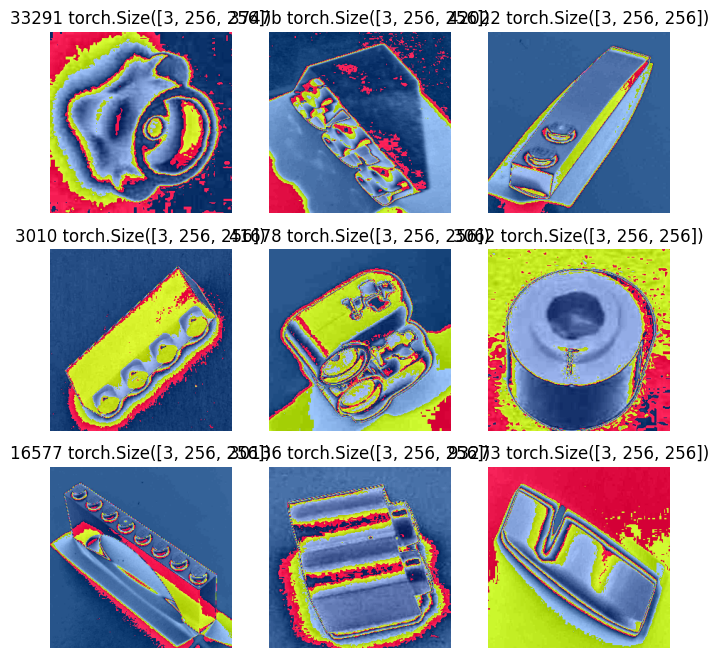

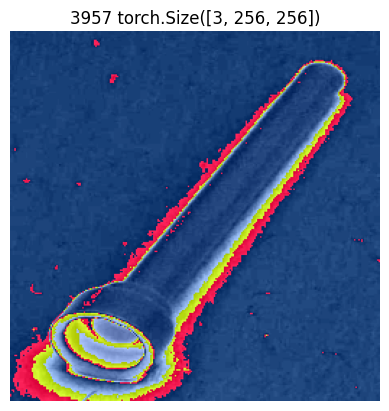

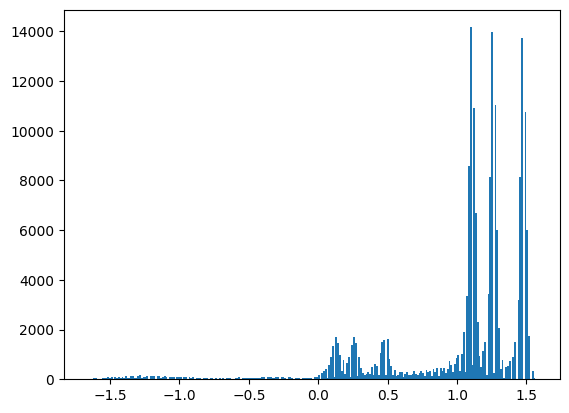

In [15]:
# Exploratory Data Analysis

ds_train_nb = len(ds_train)
ds_val_nb = len(ds_val)
ds_test_nb = len(ds_test)
total = ds_train_nb + ds_val_nb + ds_test_nb
assert total == len(ds_all)
table = PrettyTable()
table.field_names = ["Set", "Count", "%"]
table.add_row(["Train", ds_train_nb, f"{100.*ds_train_nb/total:.1f} %"])
table.add_row(["Validation", ds_val_nb, f"{100.*ds_val_nb/total:.1f} %"])
table.add_row(["Test", ds_test_nb, f"{100.*ds_test_nb/total:.1f} %"])
print(table)

# plot a grid
cols, rows = 3, 3
sample_ids = torch.randint(len(ds_train), size=(cols*rows,))
figure = plt.figure(figsize=(8, 8))
for i in range(0, cols * rows):
    sample_idx = sample_ids[i]
    img, label = ds_train[sample_idx]
    figure.add_subplot(rows, cols, i+1)
    plt.title(f"{ds_all.classes[label]} {img.shape}")
    plt.axis("off")
    img = to_pil_image(img, "RGB")
    plt.imshow(img, cmap="gray")
plt.show()


# plot a single image
def plot_image_with_label(id):
    img, label = ds_train[id]
    plt.title(f"{ds_all.classes[label]} {img.shape}")
    plt.axis("off")
    img = to_pil_image(img, "RGB")
    plt.imshow(img, cmap="gray")
    plt.show()

num = 133
plot_image_with_label(num)

img, _label = ds_train[num]
plt.hist(img.flatten(), bins=255)
plt.show()

In [16]:
# Dataloader
dataloader_train = DataLoader(ds_train, batch_size=16, shuffle=True)
dataloader_val = DataLoader(ds_val, batch_size=16, shuffle=True)
dataloader_test = DataLoader(ds_test, batch_size=16, shuffle=True)

In [27]:
# Model

class Classifier(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.lr = 1e-3
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=number_of_classes,
        )
        self.train_loss = torchmetrics.MeanMetric()
        #self.train_loss = torchmetrics.MeanMetric()
        #self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        # model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
        # Replace old FC layer with Identity so we can train our own
        linear_size = list(self.model.children())[-1].in_features
        # replace final layer for fine-tuning
        self.model.fc = nn.Linear(linear_size, number_of_classes)

        # only tune the fully-connected layers
        # for child in list(self.model.children())[:-1]:
        #     for param in child.parameters():
        #         param.requires_grad = False

    def forward(self, x):
        return self.model(x)

    def _step(self, batch):
        x, y = batch
        logits = self(x)

        loss = self.loss_fn(logits, y)
        acc = self.train_accuracy(logits, y)
        return loss, acc

    def training_step(self, batch, batch_idx):
        self.model.train()
        train_loss, train_accuracy = self._step(batch)
        self.log("train/acc_step", train_accuracy, prog_bar=True)
        self.log("train/loss_step", train_loss, prog_bar=True)

        return train_loss
    
    def on_train_epoch_end(self):
        # log epoch metric
        self.log("train/acc_epoch", self.train_accuracy)
        self.log("train/loss_epoch", self.train_loss)

    def validation_step(self, batch, batch_idx):
        self.model.eval()
        with torch.no_grad():
            loss, acc = self._step(batch)
            # perform logging
            self.log("val/loss", loss)
            self.log("val/acc", acc)

    def test_step(self, batch, batch_idx):
        # TODO eval
        loss, acc = self._step(batch)
        # perform logging
        self.log("test/loss", loss)
        self.log("test/acc", acc)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), self.lr)

In [44]:
fast_dev_run=False


mlf_logger = MLFlowLogger(experiment_name="lightning_logs", tracking_uri="file:./ml-runs")

trainer = L.Trainer(
    devices="auto",
    accelerator=accelerator,
    precision="32",
    fast_dev_run=fast_dev_run,
    max_steps=-1,
    max_epochs=10,
    enable_checkpointing=True,
    logger=mlf_logger,
    default_root_dir=CHECKPOINTS_DIR,
    overfit_batches=1,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
def main():
    dataloader_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=10, persistent_workers=True)

    model = Classifier()
    trainer.fit(model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_val)
    print(f"Metrics:  {trainer.logged_metrics}")

if IN_COLAB:
    main()
elif __name__ == '__main__':
    main()


Using cache found in /Users/lukaswoodtli/.cache/torch/hub/pytorch_vision_v0.10.0

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | loss_fn        | CrossEntropyLoss   | 0      | train
1 | train_accuracy | MulticlassAccuracy | 0      | train
2 | train_loss     | MeanMetric         | 0      | train
3 | model          | ResNet             | 59.1 M | eval 
--------------------------------------------------------------
59.1 M    Trainable params
0         Non-trainable params
59.1 M    Total params
236.239   Total estimated model params size (MB)
4         Modules in train mode
422       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/lukaswoodtli/Meine Ablage/cas-dl-module-compvis-part1/my_examples/.venv/fhnw_computer_vision_mit_deep_learning_projekt/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 0:  69%|██████▊   | 813/1184 [30:24<13:52,  0.45it/s, v_num=a4e0, train/acc_step_step=0.000, train/loss_step_step=5.610] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


In [43]:
# !mlflow ui --backend-store-uri ./ml-runs

[2024-11-19 22:15:19 +0100] [5040] [INFO] Starting gunicorn 23.0.0
[2024-11-19 22:15:19 +0100] [5040] [INFO] Listening at: http://127.0.0.1:5000 (5040)
[2024-11-19 22:15:19 +0100] [5040] [INFO] Using worker: sync
[2024-11-19 22:15:19 +0100] [5041] [INFO] Booting worker with pid: 5041
[2024-11-19 22:15:19 +0100] [5042] [INFO] Booting worker with pid: 5042
[2024-11-19 22:15:19 +0100] [5043] [INFO] Booting worker with pid: 5043
[2024-11-19 22:15:19 +0100] [5044] [INFO] Booting worker with pid: 5044
^C
[2024-11-19 22:18:56 +0100] [5040] [INFO] Handling signal: int
[2024-11-19 22:18:57 +0100] [5043] [INFO] Worker exiting (pid: 5043)
[2024-11-19 22:18:57 +0100] [5041] [INFO] Worker exiting (pid: 5041)
[2024-11-19 22:18:57 +0100] [5042] [INFO] Worker exiting (pid: 5042)
[2024-11-19 22:18:57 +0100] [5044] [INFO] Worker exiting (pid: 5044)


In [12]:
# fast.ai
!pip install fastai fastbook

In [11]:

from fastbook import *
from fastai.vision.augment import Resize
from fastai.vision.data import ImageBlock
from fastai.vision.learner import vision_learner
from torchvision.models.quantization import resnet18

In [30]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
# TODO
data_set_transforms = transforms.Compose(
    [transforms.ToTensor().to(torch.float32),
     transforms.Normalize(mean=mean, std=std),
    ])

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256)],
    batch_tfms = aug_transforms
).dataloaders(photos_data_set)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)




epoch,train_loss,valid_loss,error_rate,time
0,2.420757,1.595816,0.389296,06:31


epoch,train_loss,valid_loss,error_rate,time
0,1.389341,0.898263,0.237190,07:58
1,0.897254,0.565321,0.150204,07:55
2,0.670765,0.493748,0.129100,07:48


In [76]:
all_parts = set()
for dirpath, dirnames, filenames in os.walk(DATA_DIR / 'data_set'):
    if dirpath.endswith("photos") or dirpath.endswith("renders"):
        all_parts.update(dirnames)

all_parts_list=",".join(all_parts)
num_all_parts=len(all_parts)
num_all_parts

448

In [85]:
part_names = dict()

resp = requests.get(url=f"https://rebrickable.com/api/v3/lego/parts/?part_nums={all_parts_list}&page_size={num_all_parts}&key=8c671f0b3721b06dabb9332a6ff3c80a&inc_color_details=0")
parts_info = json.loads(resp.text)
for part_info in parts_info['results']:
    part_num = part_info['part_num']
    part_name = part_info['name']
    assert part_name not in part_names
    part_names[part_num] = part_name

for part in all_parts:
    if part not in part_names:
        part_names[part] = part

assert len(part_names) == num_all_parts

json.dump(part_names, open(SCRIPT_DIR / 'part_names.json', 'w'))
    